In [ ]:
!pip install torch_geometric

In [40]:
# import torch
# import torch.nn.functional as F
# from torch_geometric.data import Data, DataLoader
# from torch_geometric.nn import GCNConv
import numpy as np
import jax.numpy as jnp
import jraph
from jraph import GraphConvolution, GraphMapFeatures
from flax import nnx
import logging
from tqdm.notebook import tqdm # progress bar
import optax
logging.basicConfig(level=logging.INFO)
import matplotlib. pyplot as plt

In [2]:
# Define the domain and discretization
nx, ny = 20, 20  # Grid size
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xx, yy = np.meshgrid(x, y)
print(yy.ravel().shape)
nodes_pos = jnp.array(np.vstack([xx.ravel(), yy.ravel()]).T)  # Graph nodes' coordinates
num_nodes = jnp.array([nx*ny])

(400,)


In [3]:
# Define edges: connect each node to its neighbors
edges = []
for i in range(nx):
    for j in range(ny):
        if i < nx - 1:  # Horizontal edges
            edges.append([i * ny + j, (i + 1) * ny + j])
            edges.append([(i + 1) * ny + j, i * ny + j])
        if j < ny - 1:  # Vertical edges
            edges.append([i * ny + j, i * ny + (j + 1)])
            edges.append([i * ny + (j + 1), i * ny + j])
print(edges)
# edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_index = jnp.array(edges).T
senders = edge_index[0]
num_edges = jnp.array(len(senders))
receivers = edge_index[1]
print(edge_index, num_edges)

[[0, 20], [20, 0], [0, 1], [1, 0], [1, 21], [21, 1], [1, 2], [2, 1], [2, 22], [22, 2], [2, 3], [3, 2], [3, 23], [23, 3], [3, 4], [4, 3], [4, 24], [24, 4], [4, 5], [5, 4], [5, 25], [25, 5], [5, 6], [6, 5], [6, 26], [26, 6], [6, 7], [7, 6], [7, 27], [27, 7], [7, 8], [8, 7], [8, 28], [28, 8], [8, 9], [9, 8], [9, 29], [29, 9], [9, 10], [10, 9], [10, 30], [30, 10], [10, 11], [11, 10], [11, 31], [31, 11], [11, 12], [12, 11], [12, 32], [32, 12], [12, 13], [13, 12], [13, 33], [33, 13], [13, 14], [14, 13], [14, 34], [34, 14], [14, 15], [15, 14], [15, 35], [35, 15], [15, 16], [16, 15], [16, 36], [36, 16], [16, 17], [17, 16], [17, 37], [37, 17], [17, 18], [18, 17], [18, 38], [38, 18], [18, 19], [19, 18], [19, 39], [39, 19], [20, 40], [40, 20], [20, 21], [21, 20], [21, 41], [41, 21], [21, 22], [22, 21], [22, 42], [42, 22], [22, 23], [23, 22], [23, 43], [43, 23], [23, 24], [24, 23], [24, 44], [44, 24], [24, 25], [25, 24], [25, 45], [45, 25], [25, 26], [26, 25], [26, 46], [46, 26], [26, 27], [27, 26

In [53]:
# Define node features: (x, y, initial guess for u)
node_features = jnp.array(jnp.c_[nodes_pos, np.zeros((nx * ny, 1))])

In [54]:
# Create jraph graph
graph = jraph.GraphsTuple(
    nodes=node_features,
    edges=None,
    senders=senders,
    receivers=receivers,
    n_node=num_nodes,
    n_edge=num_edges,
    globals=None
    )

In [75]:
# Define the source term f(x, y) for the Poisson equation
def source_term(x, y):
    return jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

source_values = jnp.array(source_term(nodes_pos[:, 0], nodes_pos[:, 1])).reshape(-1,1)
print(source_values.shape)

(400, 1)


Define the GCN architecture:

In [76]:
class GCN(nnx.Module):
  def __init__(self, in_features, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(in_features, 16, rngs=rngs)
    self.linear2 = nnx.Linear(16, 32, rngs=rngs)
    self.linear3 = nnx.Linear(32, 1, rngs=rngs)

  def __call__(self, graph):
    self._gn1 = GraphConvolution(update_node_fn=self.linear1)
    self._gn2 = GraphConvolution(update_node_fn=self.linear2)
    self._gn3 = GraphConvolution(update_node_fn=self.linear3)
    self._act = GraphMapFeatures(embed_node_fn=nnx.relu)
    y = self._gn1(graph)
    y = self._act(y)
    y = self._gn2(y)
    y = self._act(y)
    y = self._gn3(y)
    return y.nodes

In [77]:
model = GCN(3, nnx.Rngs(42))
model(graph)

Array([[-0.00089669],
       [ 0.00362597],
       [ 0.01137426],
       [ 0.0213886 ],
       [ 0.03088619],
       [ 0.04037311],
       [ 0.04983666],
       [ 0.05946446],
       [ 0.06896724],
       [ 0.07850097],
       [ 0.08824807],
       [ 0.09807601],
       [ 0.10800057],
       [ 0.1179389 ],
       [ 0.12787725],
       [ 0.13781558],
       [ 0.14945929],
       [ 0.158808  ],
       [ 0.17599872],
       [ 0.14066777],
       [-0.00515392],
       [-0.00199846],
       [ 0.00628605],
       [ 0.01624296],
       [ 0.02796955],
       [ 0.0395575 ],
       [ 0.0511561 ],
       [ 0.06191746],
       [ 0.07253241],
       [ 0.08314388],
       [ 0.09378216],
       [ 0.10469042],
       [ 0.11563697],
       [ 0.12665355],
       [ 0.13769238],
       [ 0.14851135],
       [ 0.15968159],
       [ 0.17508034],
       [ 0.18480143],
       [ 0.17336807],
       [-0.0122317 ],
       [-0.01136089],
       [-0.00588452],
       [ 0.00254566],
       [ 0.01233309],
       [ 0

Training functions:

In [78]:
@nnx.jit
def loss_fn(model, graph, labels):
    output_graph_nodes = model(graph)
    loss = optax.losses.l2_loss(output_graph_nodes, labels)
    return jnp.mean(loss)

# Train for a single epoch
@nnx.jit
def train_step(model, optimizer, graph, labels):
    loss, grads = nnx.value_and_grad(loss_fn)(model, graph, labels)
    optimizer.update(grads)
    return loss

def train(model, optimizer, graph, labels, epochs, log_period_epoch=1, show_progress=True):

    train_loss_history = []

    for epoch in tqdm(range(1, epochs + 1), disable=not show_progress):
        train_loss = train_step(model, optimizer, graph, labels)

        train_loss_history.append(train_loss)

        if epoch == 1 or epoch % log_period_epoch == 0:
            logging.info(
                "epoch:% 3d, train_loss: %.4f"
                % (epoch, train_loss)
            )
    return train_loss_history

Let's train the GCN!

In [79]:
# Define the optimizer
lr = 1e-2 # learning rate
optimizer = nnx.Optimizer(model, optax.adam(lr)) # Adam optimizer

epochs = 100
labels = source_values

train_loss_history = train(model, optimizer, graph, labels, epochs, log_period_epoch=10, show_progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

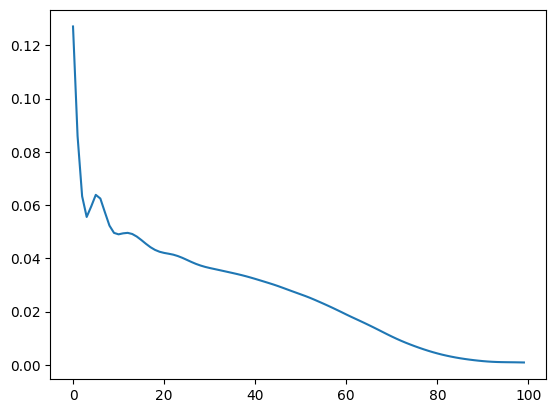

In [80]:
plt.plot(train_loss_history)

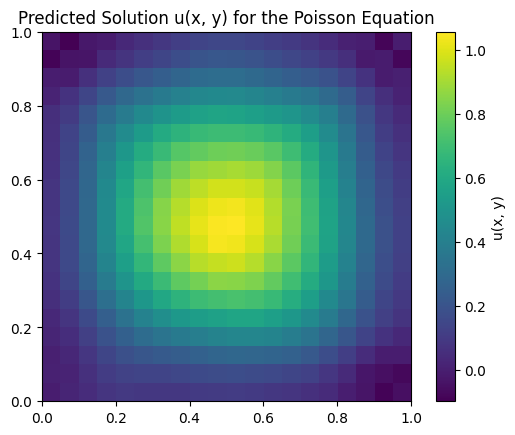

In [81]:
# Visualize the solution using matplotlib
import matplotlib.pyplot as plt
predicted_u = model(graph).reshape(nx, ny)
plt.imshow(predicted_u, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.colorbar(label='u(x, y)')
plt.title('Predicted Solution u(x, y) for the Poisson Equation')
plt.show()